In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm

from sim_biology import p, load_dataloader_and_pretrained_model
# adaptive-wavelets modules
sys.path.append('../../src')
sys.path.append('../../src/adaptive_wavelets')
from losses import get_loss_f
from train import Trainer, Validator
from transform1d import DWT1d
from utils import get_1dfilts
from wave_attributions import Attributer
from visualize import cshow, plot_1dreconstruct, plot_1dfilts
from warm_start import run_warmstart

## load data and model

In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p)

In [12]:
# get image
data = iter(test_loader).next()[0].to(device)

# wavelet transform 
wt = DWT1d(wave='db5', mode='symmetric', J=5, init_factor=0, noise_factor=0.01).to(device)

data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 1d wavelet filters
filt = get_1dfilts(wt)

Reconstruction error=45.42266


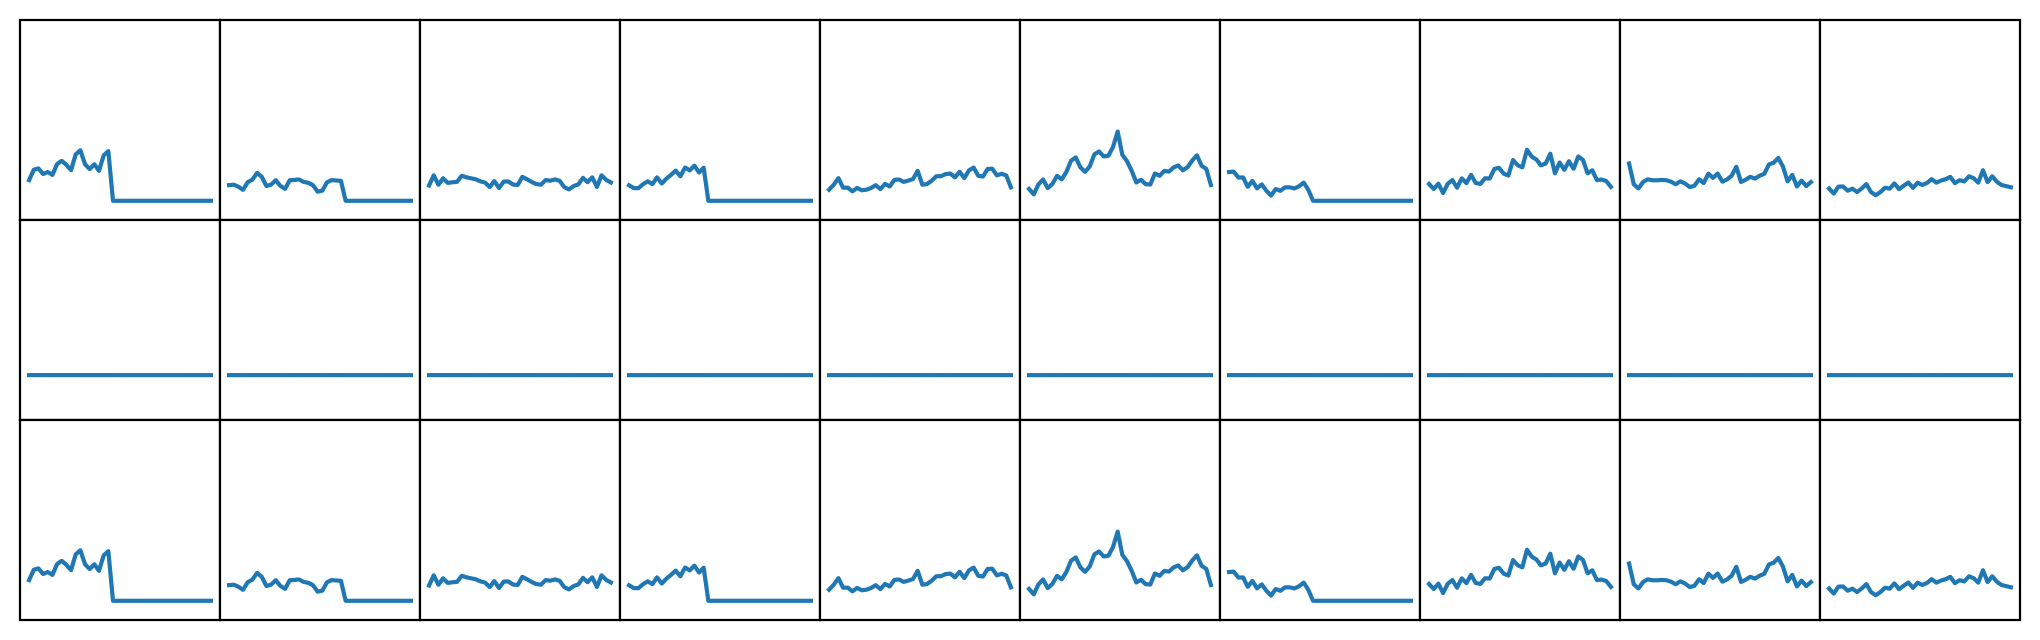

In [13]:
# plot original and reconstruction images
plot_1dreconstruct(data, recon)

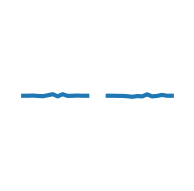

In [14]:
# plot wavelet filters
plot_1dfilts(filt, figsize=(1,1))

## optimize filter

In [15]:
# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=0.01)
loss_f = get_loss_f(lamL1attr=10)
trainer = Trainer(model, wt, Attributer, optimizer, loss_f, target=0, attr_methods='Saliency', device=device, n_print=200)

In [16]:
reg_path = np.geomspace(0.01, 500, num=20)
run_warmstart(train_loader, trainer, reg_path, epochs=1000)

	Warm starting...

***Train model at regularization parameter = 0.01***

Starting Training Loop...
Train Epoch: 0 [1044/2936 (97%)]	Loss: 6.1391129
====> Epoch: 0 Average train loss: 15.3496
Train Epoch: 200 [1044/2936 (97%)]	Loss: 0.003558
====> Epoch: 200 Average train loss: 0.0039
Train Epoch: 400 [1044/2936 (97%)]	Loss: 0.004159
====> Epoch: 400 Average train loss: 0.0037
Train Epoch: 600 [1044/2936 (97%)]	Loss: 0.004674
====> Epoch: 600 Average train loss: 0.0055
Train Epoch: 800 [1044/2936 (97%)]	Loss: 0.003473
====> Epoch: 800 Average train loss: 0.0037

***Train model at regularization parameter = 0.017673160060762083***

Starting Training Loop...
Train Epoch: 0 [1044/2936 (97%)]	Loss: 0.006351
====> Epoch: 0 Average train loss: 0.0091
Train Epoch: 200 [1044/2936 (97%)]	Loss: 0.005745
====> Epoch: 200 Average train loss: 0.0064
Train Epoch: 400 [1044/2936 (97%)]	Loss: 0.006704
====> Epoch: 400 Average train loss: 0.0065
Train Epoch: 600 [1044/2936 (97%)]	Loss: 0.005943
====> Ep

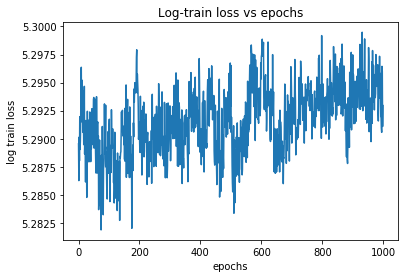

In [17]:
plt.plot(np.log(trainer.train_losses))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [18]:
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 2d wavelet filters
filt = get_1dfilts(wt)

Reconstruction error=0.00039


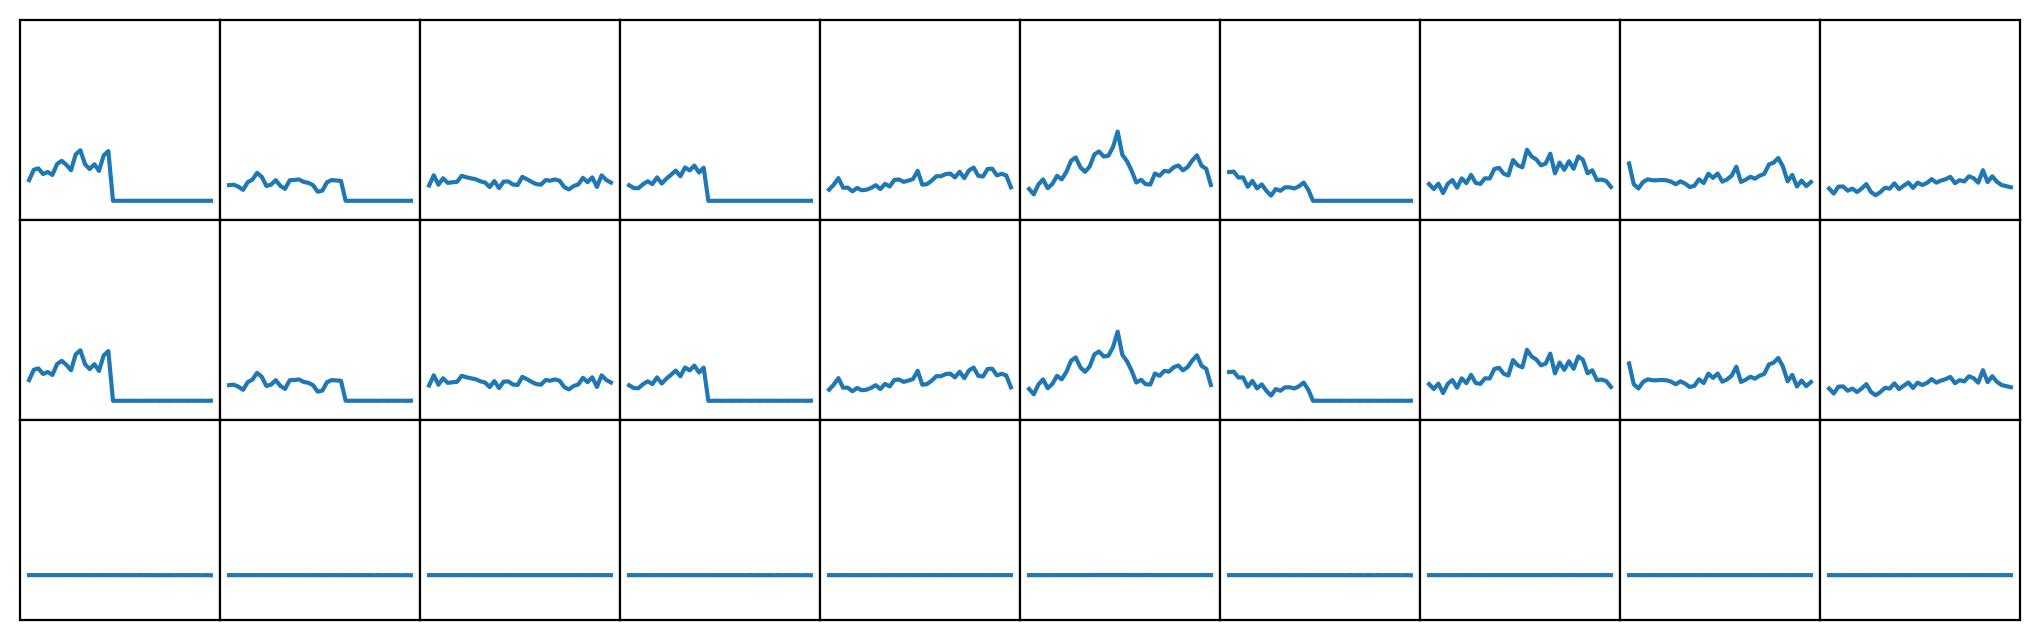

In [19]:
# plot original and reconstruction images
plot_1dreconstruct(data, recon)

## test error

In [20]:
loss_v = get_loss_f(lamL1attr=1)

# validator 
validator = Validator(model, wt, Attributer, loss_v, target=0, attr_methods='Saliency', device=device)
_, rec_loss, L1attr_loss = validator(test_loader)

# original wavelet transform
wt_o = DWT1d(wave='db5', mode='symmetric', J=5, init_factor=1, noise_factor=0).to(device)
validator_o = Validator(model, wt_o, Attributer, loss_v, target=0, attr_methods='Saliency', device=device)
_, rec_loss_o, L1attr_loss_o = validator_o(test_loader)

print("\n\n Original filter:Reconstruction Error={:.5f} L1attribution loss={:.5f} \n Adaptive filter:Reconstruction Error={:.5f} L1attribution loss={:.5f}"\
          .format(rec_loss_o, L1attr_loss_o, rec_loss, L1attr_loss))

Test: [50/1005 (91%)]	Loss: 0.4385321

 Original filter:Reconstruction Error=0.00000 L1attribution loss=0.37044 
 Adaptive filter:Reconstruction Error=0.00034 L1attribution loss=0.39231


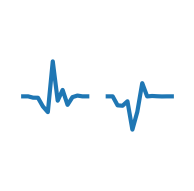

In [21]:
# plot wavelet filters
filt = get_1dfilts(wt)
plot_1dfilts(filt, figsize=(1,1))

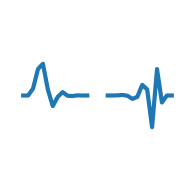

In [22]:
# plot original wavelet filters
filt_o = get_1dfilts(wt_o)
plot_1dfilts(filt_o, figsize=(1,1))